In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import pandas as pd
import random as random
import numpy as np
import scipy as sp
import networkx as nx
import warnings 
warnings.filterwarnings("ignore") # GP struggles to converge sometimes, ignored for now
import time
from sklearn.model_selection import ParameterGrid

import seaborn as sns
from matplotlib import pyplot as plt

import nklsgen
import perlin_ls_gen as plsgen
import random

In [2]:
def gather_data(agent, step):
    data = {}
    dims = [int(np.sqrt(len(agent.surveys[step])))]*2
    
    data['Survey'] = agent.surveys[step].copy().reshape(dims)
    data['EIVals'] = agent.eivals[step].copy().reshape(dims)
    data['ExpVal'] = agent.expval[step].copy().reshape(dims)
    data['Distances'] = agent.distances[step].copy().reshape(dims)
    data['Search_Loss'] = agent.search_loss[step].copy().reshape(dims)
    data['FinalVals'] = agent.finalvals[step].copy().reshape(dims)
    data['Softmax'] = agent.softmax[step].copy().reshape(dims)
    
    return data


class Graph():
    def __init__(self, edgelist, id_, density=None):
        self.id = id_
        self.edgelist = edgelist
        self.density = density

In [3]:
def extract_edgelist(G):
    nodes = list(G.nodes)
    edges = []
    
    for node in nodes:
        edges.append(sorted(list(G[node])))
        
    return dict(zip(nodes, edges))


def random_starts(landscape, points, min_=False):
    ls_dict = dict(np.ndenumerate(landscape))
    items = list(ls_dict.items()).copy()
    if min_:
        ls_size = len(landscape)
        tenth = int(round(ls_size/min_, 0))
        decile = sorted(items, key=lambda x: x[1])[:tenth]
        picks = random.choices(decile, k=points)
    else:    
        picks = random.choices(items, k=points)
    
    start_points = [[pick[0], pick[1]] for pick in picks]
    #start_points = [[nklsgen.str_to_bin(pick[0]), pick[1]] for pick in picks]
    return start_points


def one_step_genotypes(genotype):
    base = genotype.copy()
    one_steps = []
    for i in range(len(base)):
        new = base.copy()
        if new[i] == 0:
            new[i] += 1
        elif new[i] == 1:
            new[i] -= 1
        one_steps.append(new)
    return one_steps

def hist_df_maker(pop):
    hist_dfs = []
    for agent in pop.agents:
        hist_dfs.append(agent.search_hist.copy())
    return pd.concat(hist_dfs)

In [4]:
def bin_to_str(code):
    string = str()
    for each in code:
        string += (str(each))
    return string

def bin_to_str_perlin(code):
    string = str()
    for each in code:
        string += (str(each))
        string += f','
    return string[:-1]

def str_to_bin(code):
    return [int(each) for each in eval(code)]

def str_to_bin_perlin(code):
    return [int(each) for each in code.split(",")]

def bin_to_dec(bin_):
    key = np.power(2, np.flip(np.arange(len(bin_))))
    return np.sum(bin_ * key)

def distances_from_current(landscape_index, locs_bin):
    distances = [distance_from_many_to_one(point, locs_bin) for point in landscape_index]
    return distances

def distance_from_many_to_one(point, locs_bin): 
    distances = [euclidean_distance(point, loc) for loc in locs_bin]
    return min(distances)

def euclidean_distance(a, b):
    val = np.sum([(b[i]-a[i])**2 for i in range(len(a))])
    return np.sqrt(val)

def vectorized_dist(curr_loc, neigh_locs, landscape_index):
    curr_dists = sp.spatial.distance.cdist(landscape_index, curr_loc, 'cityblock')
    if len(neigh_locs) > 0:
        neigh_dists = sp.spatial.distance.cdist(landscape_index, neigh_locs, 'cityblock') + 1
        all_dists = np.concatenate([curr_dists, neigh_dists], axis=1)
    else:
        all_dists = curr_dists
    return all_dists.min(axis=1)

In [5]:
class Agent():

    def __init__(self, search_cost=0, memory=None, wmemory=None, ei=0, myopic=False, 
                 edgelist=None, id_=None, start_point=None, landscape_index=None):
        
        self.id = id_
        self.myopic = myopic
        self.landscape_index = landscape_index
        self.ei = ei
            
        self.search_cost = search_cost    
        self.memory = memory
        self.wmemory = wmemory
        self.edgelist = edgelist
        self.neighbors = []
        
        start_point.append(self.id)
        start_point.append(0)
        self.search_hist = pd.DataFrame(columns=['Location', 'Value', 'AgentID', 'Step'])
        self.search_hist.loc[len(self.search_hist)] = start_point
        
        self.shared_search_hist = self.search_hist.copy()
        self.model_hist = []
        self.timeperround = []

        self.surveys = []
        self.eivals = []
        self.expval = []
        self.distances = []
        self.search_loss = []
        self.finalvals = []
        self.softmax = []
        
        # GP kernel parameters
        self.kernel = RBF(length_scale=5,
                          length_scale_bounds=(1e-5,1e8))
        self.gp = GaussianProcessRegressor(kernel=self.kernel,
                                           n_restarts_optimizer=0)
        
        
    def update_shared_hist(self, teach=False, learn=True):
        for agent in self.neighbors:
            new_data = agent.search_hist.iloc[-1,:].values.tolist()
            self.shared_search_hist.loc[len(self.shared_search_hist)] = new_data
            
            
    def survey(self, relevant_hist):                
        locs = relevant_hist['Location'].tolist()
        vals = relevant_hist['Value'].tolist()
        self.gp.fit(locs, vals)
        y_est, std = self.gp.predict(self.landscape_index, return_std=True)
        y_est[y_est < 0.001] = 0
        
        self.model_hist.append(relevant_hist.copy()) ###
        self.surveys.append(y_est.copy()) ###
        
        return y_est, std

    
    def choose_new_point(self, landscape, capped=True): 
        
        # Select Relevant History
        amount = ((len(self.neighbors)+1) * self.memory)
        if capped:
            opts = self.shared_search_hist.sort_values(by=['Step'])[-amount:].index.tolist()
            if len(opts) < self.wmemory:
                inds = random.sample(opts, k=len(opts))
            else:
                inds = random.sample(opts, k=self.wmemory)
            relevant_hist = self.shared_search_hist[self.shared_search_hist.index.isin(inds)].copy()
        else:
            relevant_hist = self.shared_search_hist.sort_values(by=['Step'])[-amount:].copy() 
        
        # Pass Relevant History to Survey() + Calc Expected_Value
        y_est, std_ = self.survey(relevant_hist.copy())
        self.eivals.append(std_.copy()) ###
        std = std_ * self.ei
        
        expected_value = y_est + std
        self.expval.append(expected_value) ###
        
        max_ = expected_value.max()
        expected_value = expected_value / max_ 
        
        # Distances 
        curr_loc_df = self.search_hist.sort_values(by=['Step'])[-1:].copy()
        self_idx = relevant_hist[(relevant_hist['AgentID']==curr_loc_df.iloc[-1,2]) &
                                (relevant_hist['Step']==curr_loc_df.iloc[-1,3])].index
        relevant_hist.drop(index=self_idx, inplace=True)

        curr_loc = np.array(curr_loc_df['Location'].tolist())
        neigh_locs = np.array(relevant_hist['Location'].tolist())

        distances = vectorized_dist(curr_loc, neigh_locs, np.array(self.landscape_index.copy()))
        self.distances.append(distances) ###

        ## Search Cost
        max_dist = distances.max()
      # search_loss = distances / max_dist
        search_loss = distances
        search_loss = search_loss * np.array(self.search_cost)
        self.search_loss.append(search_loss) ###
        
        values = expected_value - search_loss
        self.finalvals.append(values) ###
        
        values[values < 0] = 0

        ## Softmax Choice
        tau = 0.02
        softmax = np.exp(values/tau) / sum(np.exp(values/tau))
        self.softmax.append(softmax) ###
        
        softmax_dict = dict(zip(softmax.copy(), values.copy()))
        options = dict(sorted(softmax_dict.items(), reverse=True))
        choice = random.choices(list(options.values()), weights=list(options.keys()), k=1) 
        loc = np.where(values == choice)[0][0] 
                    
        return self.landscape_index[loc]
    
    
    def choose_and_move(self, landscape):
        new_loc = self.choose_new_point(landscape)
        new_val = landscape[new_loc]
        
        self.search_hist.loc[len(self.search_hist)] = [new_loc, new_val, self.id, len(self.search_hist)]
        self.shared_search_hist.loc[len(self.shared_search_hist)] = self.search_hist.iloc[-1,:].values.tolist()
    
    
    def explore(self, landscape, steps):
        for _ in range(steps):
            start = time.perf_counter()
            self.choose_and_move(landscape)
            self.timeperround.append(round((time.perf_counter()-start), 4))

class Population():
    
    def __init__(self, ls_params, num_searches, graph,
                 search_costs, memorys, wmemorys, eis, myopia,
                 pop_id=None, graph_id=None):

        # Landscape Creation/Index
        self.ls_params = ls_params
        self.landscapes = nklsgen.generate_landscapes(ls_params['N'], ls_params['K'], 
                                                      base=ls_params['base'], smooth=ls_params['smooth'])
        self.landscape = self.landscapes[0].copy()
        # Weird prevention of null survey
        self.landscape[self.landscape<0.01] = 0.01
        
        # self.landscape_index = list(self.landscape.keys())
        self.landscape_index = [loc for loc, val in np.ndenumerate(self.landscape)]
        
        self.num_searches = num_searches
        
        # Agents and Properties
        self.search_costs = search_costs
        self.memorys = memorys
        self.wmemorys = wmemorys
        self.eis = eis
        self.myopia = myopia
        self.graph = graph
        self.edgelist = graph.edgelist
        self.graphdensity = graph.density
        
        # ID Attributes
        self.pop_id = pop_id
        self.graph_id = graph.id
        # self.landscape_id = landscape.id_
        
        # Create Agents
        self.agents = self.create_agents()
        
    def create_agents(self):
        starts = random_starts(self.landscape, len(self.edgelist), min_=False)
        agents_ = []
        for i in range(len(self.edgelist)):
            agents_.append(Agent(self.search_costs[i], self.memorys[i], self.wmemorys[i], self.eis[i], 
                                 self.myopia, self.edgelist[i], i, starts[i], self.landscape_index))
        
        for i in range(len(self.edgelist)):
            neighbors_ = [agents_[a] for a in self.edgelist[i]]
            agents_[i].neighbors = neighbors_
            agents_[i].update_shared_hist()
        
        return agents_
    
    def report_step_averages(self, step):
        agent_vals = []
        for agent in self.agents:
            agent_vals.append(agent.search_hist['Value'][step])
        return agent_vals
        
    def report_full_hist(self):
        hist_dfs = []
        for agent in self.agents:
            hist_dfs.append(agent.search_hist.copy())
        hist_df = pd.concat(hist_dfs)
        hist_df['PopID'] = self.pop_id
        return hist_df
    
    def explore(self, sync=True):
        # Pop level explore function (round-based search)
        ## Could weave search and update together pretty easily
        ### Done by reversing the updating function
        
        for i in range(self.num_searches):
            #rts = time.time()
            for agent in self.agents:
                agent.explore(self.landscape, 1)
                
                if not sync:
                    agent.update_shared_hist()
             
            if sync:
                for agent in self.agents:
                    agent.update_shared_hist()
            
            #rtstop = time.time()
            #print(f'Pop:{self.pop_id}, Round:{i} took {round(rts-rtstop,0)} seconds!')
                    
        #print(f'Sim {self.pop_id} Complete!')
        
        
def run_model(p_combo):
    pop = Population(ls_params = p_combo['ls_params'],  
                     num_searches = p_combo['num_searches'], 
                     graph = p_combo['graphs'],
                     search_costs = p_combo['search_costs'],
                     memorys = p_combo['memorys'],
                     wmemorys = p_combo['wmemorys'],
                     eis = p_combo['eis'],
                     myopia = p_combo['myopia'],
                     pop_id = p_combo['pop_id'])
    
    pop.explore()

    
    return pop

In [6]:
import random
import pickle
from networkx import gnm_random_graph
import networkx as nx
from networkx import density

from ABM import Graph
from ABM import Landscape
from ABM import extract_edgelist

from sklearn.model_selection import ParameterGrid

# Sim Properties
num_searches = [10]
num_sims = 1

# Landscape Properties     
N = [2]
# N = [a for a in range(6,16)]
K = [1]
# K = [a for a in range(10,11)]

num_of_ls = [1]
ls_param_grid = {'N': N, 'K': K, 'base': [10], 'smooth':[[2,1,0]]}
ls_params = list(ParameterGrid(ls_param_grid))

# Agent Properties (1,1,6)
search_costs__ = [0]
# search_costs__ = [a/1000 for a in list(range(0,11,5))]

memorys_ = [100]
# memorys_ = [a for a in range(1,11)]

wmemorys_ = [100]
# wmemorys_ = [a for a in range(1,11)]

# eis_ = [a/10 for a in list(range(0,6))]
eis_ = [0]
myopia = [False]

# Premade Check
premade = False

# Unpickle Graphs/Landscapes
graph_file = 'PNASGraphs.pickle'
if premade:
    with open(graph_file, 'rb') as f:
        edgelists = pickle.load(f) 
    edgelists = edgelists[0:2]

# Create Graphs/Landscapes (100)
elif not premade:
    num_agents = 1
    densities = [i/10 for i in list(range(10,11))]
    edges = [round(((num_agents*(num_agents-1)) / 2) * dens, 0) for dens in densities]
    #edges = list(range(0,120,8))
    #edges = [0]
    num_graphs = 1
    
    graphs_ = []     
    for edge in edges:
        # GNM Graph
        graphs_.append([gnm_random_graph(num_agents, edge) for _ in range(num_graphs)])
        
        # # Chain Graph
        # for _ in range(num_graphs):
        #     G = nx.Graph()
        #     for i in range(1,num_agents):
        #         G.add_edge(i-1,i)
        #     graphs_.append([G])
            
    graphs_ = [graph[i] for graph in graphs_ for i in range(len(graph))] 
    edgelists = [extract_edgelist(g) for g in graphs_]
    

# Create special graph objects
graphs = []
for i, edgelist in enumerate(edgelists):
    if premade:
        graphs.append(Graph(edgelist, i))
    if not premade:
        graphs.append(Graph(edgelist, i, density(graphs_[i])))
        
# # Create special landscape objects
# landscapes = []
# for i, landscape_ in enumerate(landscapes_):
#     landscapes.append(Landscape(landscape_, i))


# Graph Properties (need edgelists made before this works)
num_agents = len(list(edgelists[0].keys()))
search_costs = [[i for _ in range(num_agents)] for i in search_costs__]
memorys = [[i for _ in range(num_agents)] for i in memorys_]
wmemorys = [[i for _ in range(num_agents)]for i in wmemorys_]
eis = [[i for _ in range(num_agents)] for i in eis_]

# Create Simulation ParamGrid
parameter_grid = {'ls_params': ls_params,  
                'num_searches': num_searches, 
                'graphs': graphs,
                'search_costs': search_costs,
                'memorys': memorys,
                'wmemorys': wmemorys,
                'eis': eis,
                'myopia': myopia}

# Create list of Param_Combos
parameter_combos = list(ParameterGrid(parameter_grid))
parameter_combos = [a.copy() for a in parameter_combos.copy() for _ in range(num_sims)]

for i, pcombo in enumerate(parameter_combos):
    pcombo.update({'pop_id': i})

sim_start = time.time()
sim_hist = []
for p_combo in parameter_combos:
    sim_start_ = time.time()
    sim_hist.append(run_model(p_combo))
#     print(f'Sim Complete: {time.time()-sim_start_}')
time_ = round(time.time()-sim_start, 0) / len(parameter_combos)
print(f'Total Time: {time_*len(parameter_combos)}')
print(f'Time/Sim: {time_}')

Total Time: 0.0
Time/Sim: 0.0


In [12]:
# parameter_combos

<Axes: >

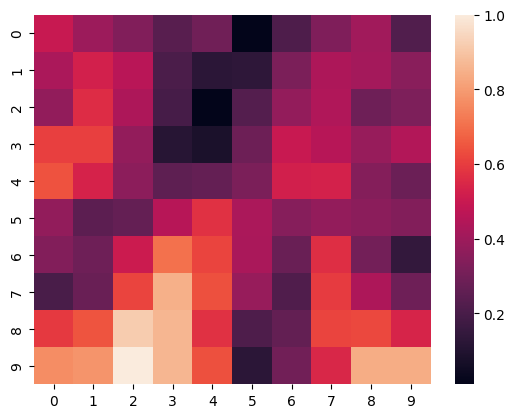

In [203]:
ls = np.array(sim_hist[0].landscape).reshape(10,10)
sns.heatmap(pd.DataFrame(ls))

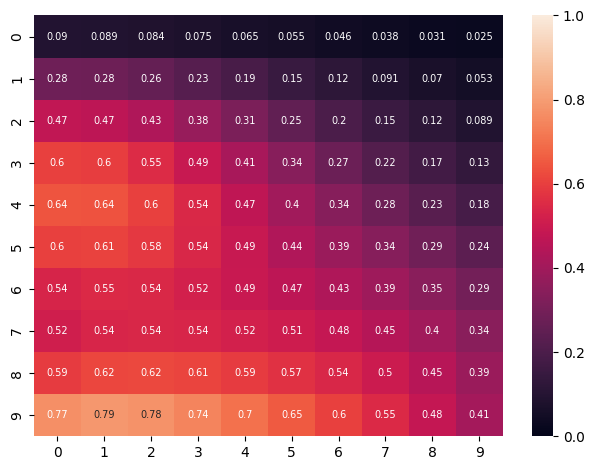

In [236]:
survey = np.array(sim_hist[0].agents[0].surveys[6]).reshape(10,10).round(3)
temp = pd.DataFrame(survey)
sns.heatmap(temp, cmap='rocket', vmin=0,vmax=1,
            annot=True, annot_kws={'size': 7})
# plt.title(f'Survey')
plt.tight_layout()
plt.savefig('output/survey6.jpeg')
plt.show()

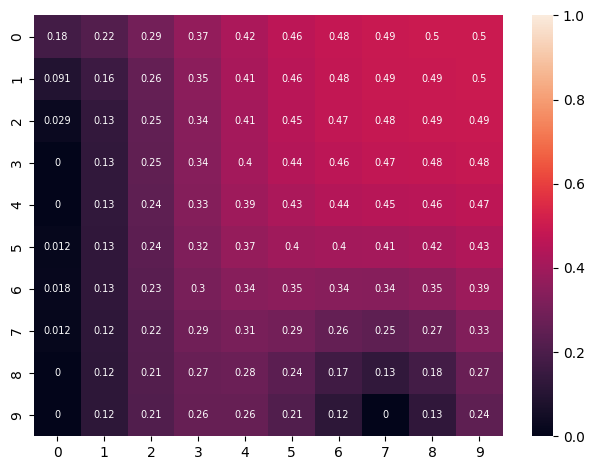

In [237]:
eivals = np.array(sim_hist[0].agents[0].eivals[6]).reshape(10,10).round(3)*0.5
temp = pd.DataFrame(eivals)
sns.heatmap(temp, cmap='rocket', vmin=0,vmax=1,
            annot=True, annot_kws={'size': 7})
# plt.title(f'Standard Deviations')
plt.tight_layout()
plt.savefig('output/curiosity6.jpeg')
plt.show()

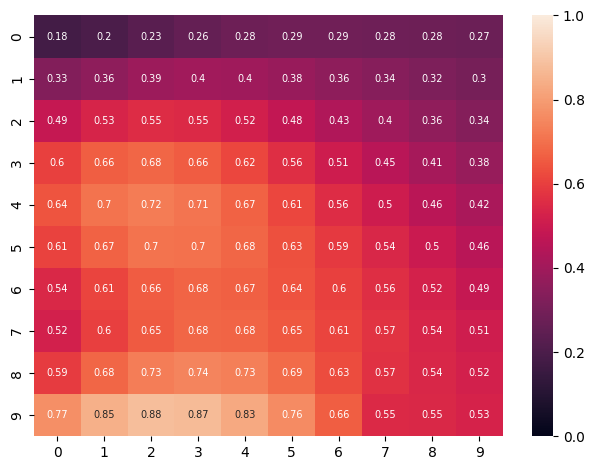

In [238]:
test1 = survey + (eivals*0.5)
temp = pd.DataFrame(test1)
sns.heatmap(temp, cmap='rocket', vmin=0,vmax=1,
            annot=True, annot_kws={'size': 7})
# plt.title(f'Survey w/ Curiosity')
plt.tight_layout()
plt.savefig('output/surv_cur_6.jpeg')
plt.show()

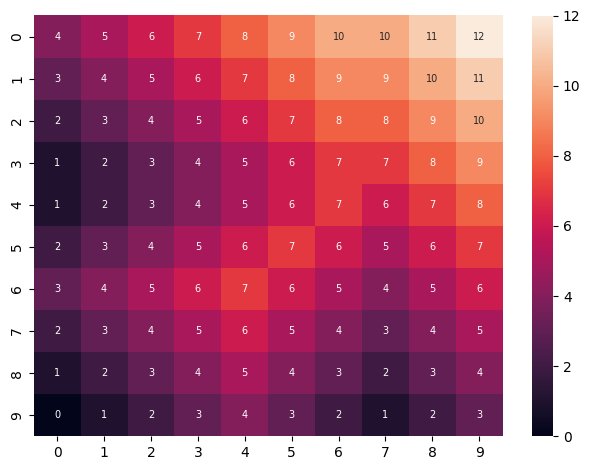

In [246]:
dists = np.array(sim_hist[0].agents[0].distances[6]).reshape(10,10).round(3)
temp = pd.DataFrame(dists)
sns.heatmap(temp, cmap='rocket',
            annot=True, annot_kws={'size': 7})
# plt.title(f'Distances')
plt.tight_layout()
plt.savefig('output/dist6.jpeg')
plt.show()

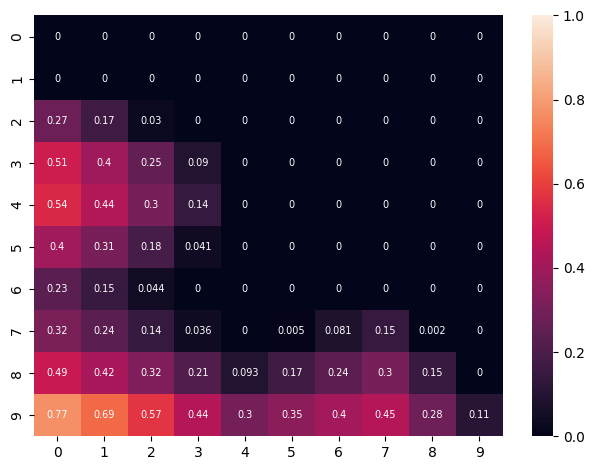

In [245]:
test = survey-(0.1*dists)
test[test<0] = 0
temp = pd.DataFrame(test)
sns.heatmap(temp, cmap='rocket', vmin=0,vmax=1,
            annot=True, annot_kws={'size': 7})
# plt.title(f'Survey-(Search_Cost * Distances)')
plt.tight_layout()
plt.savefig('output/sur_dist6.jpeg')
plt.show()

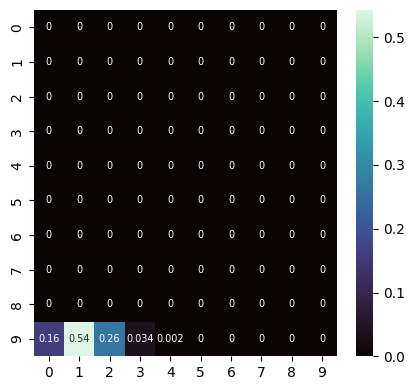

In [229]:
fig = plt.figure(figsize=(4.33,4))

survey = np.array(sim_hist[0].agents[0].softmax[6]).reshape(10,10).round(3)
temp = pd.DataFrame(survey)
sns.heatmap(temp, cmap='mako',
            annot=True, annot_kws={'size': 7})
# plt.title(f'Agent Choices')
plt.tight_layout()
plt.savefig('output/choices6.jpeg')
plt.show()

In [ ]:
survey = np.array(sim_hist[0].agents[0].softmax[8]).reshape(10,10).round(3)
temp = pd.DataFrame(survey)
sns.heatmap(temp, cmap='mako',
            annot=True, annot_kws={'size': 7})
plt.title(f'Agent Choices')
plt.tight_layout()
plt.show()

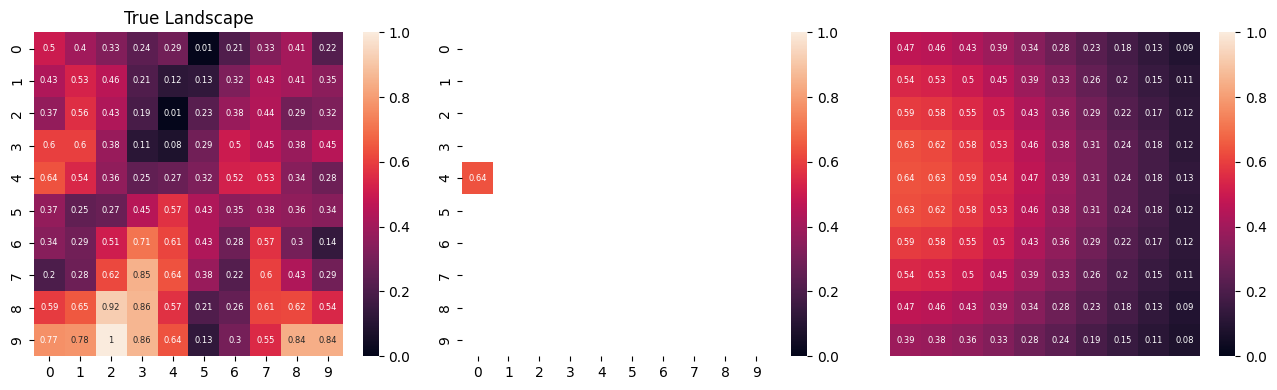

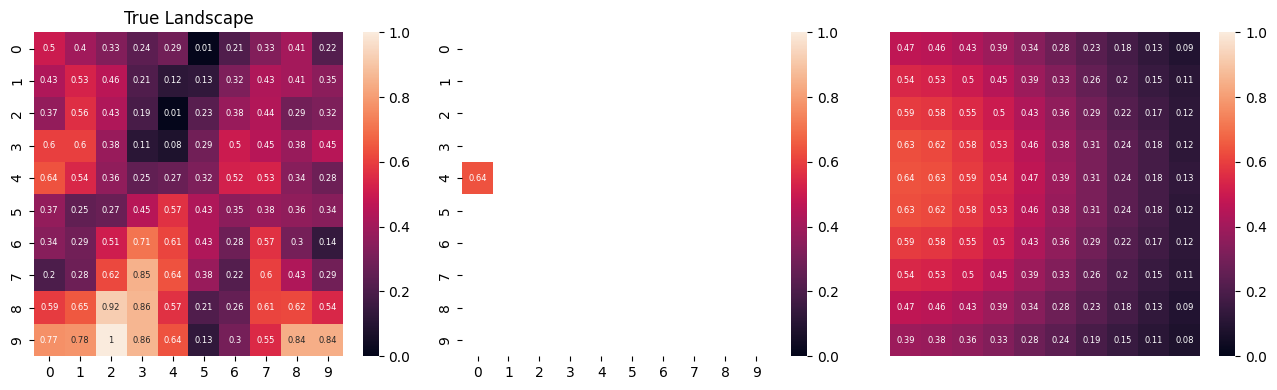

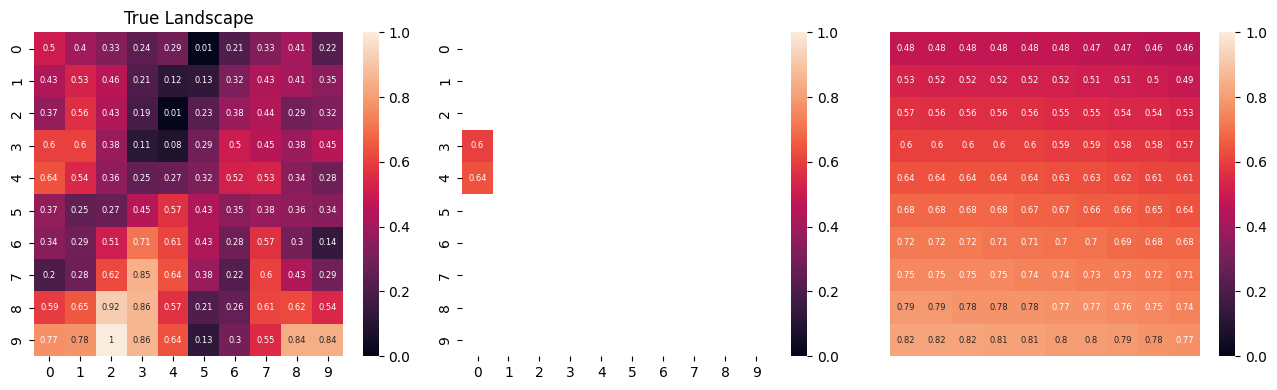

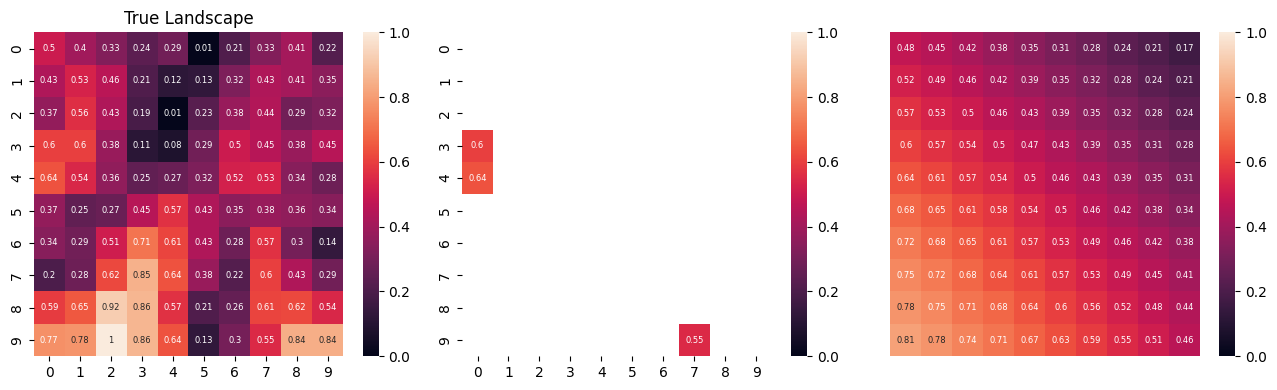

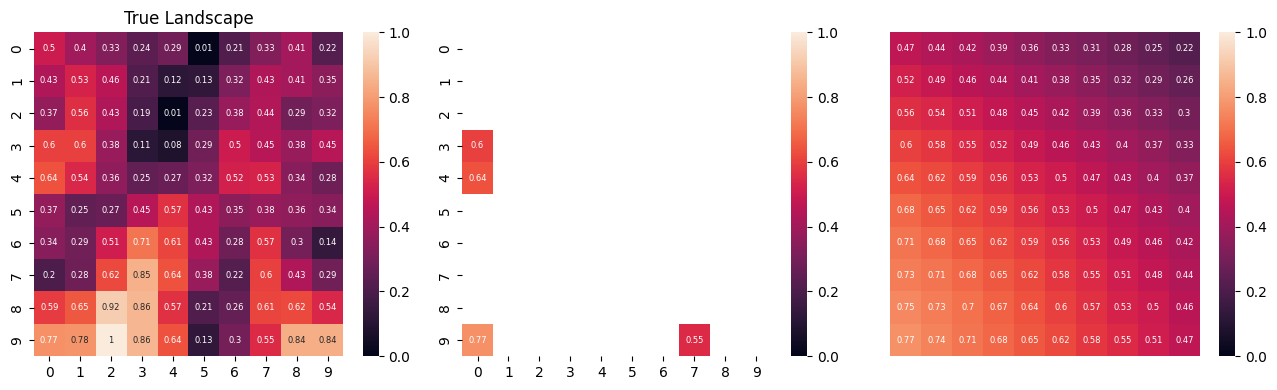

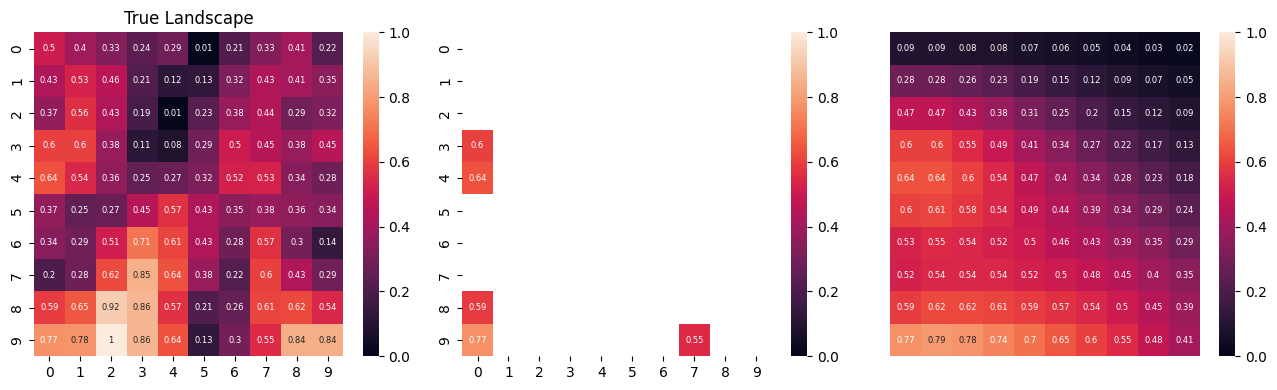

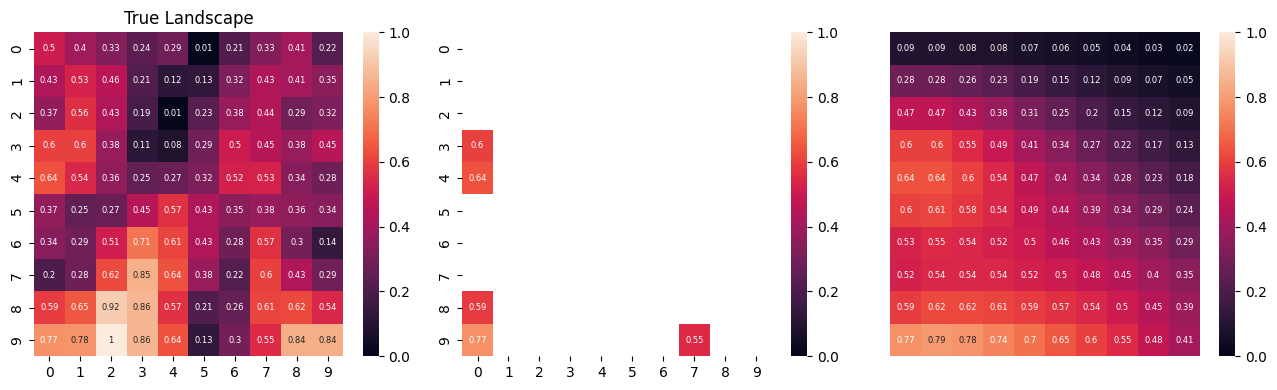

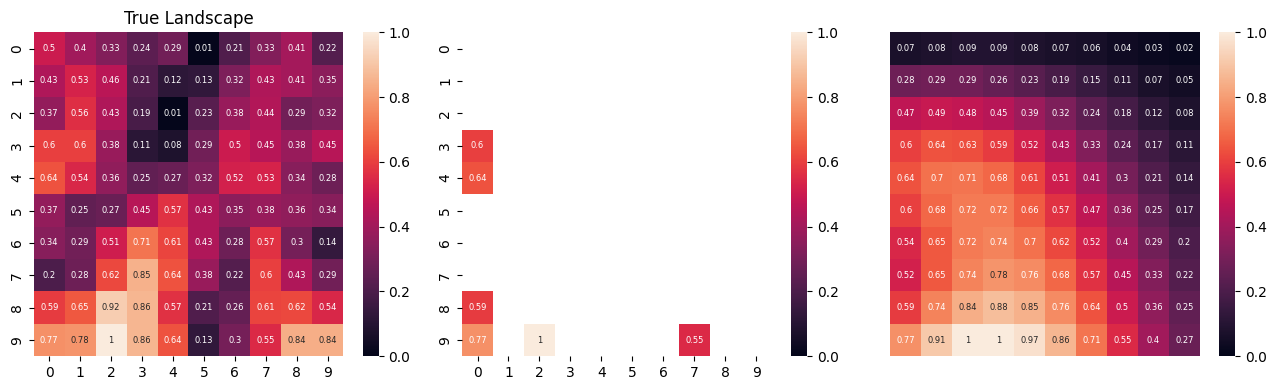

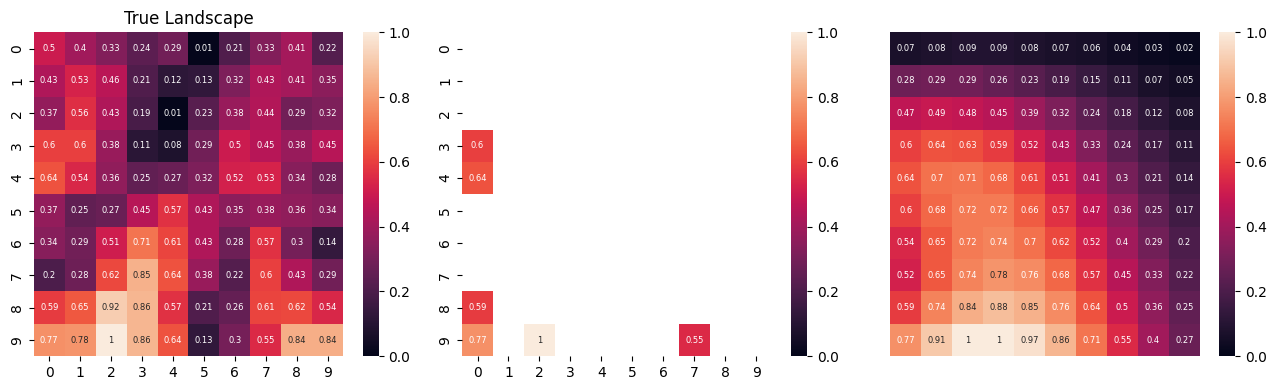

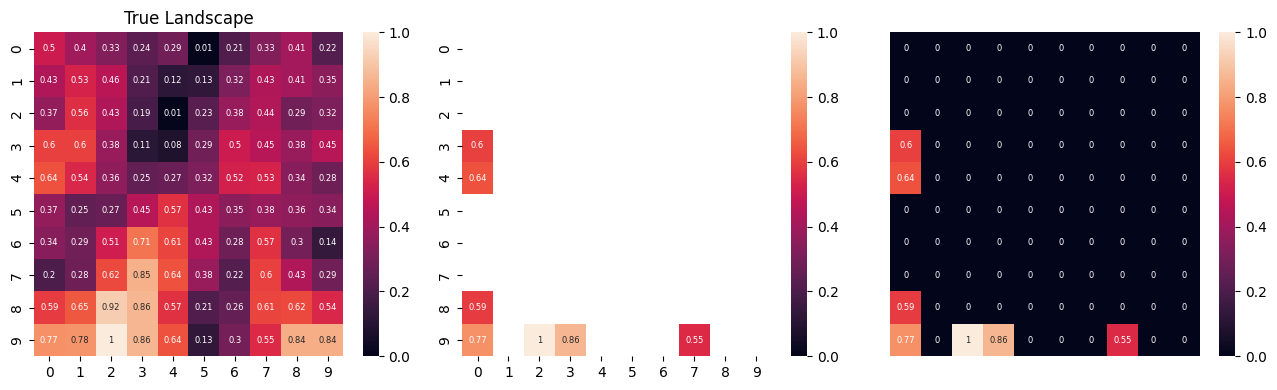

In [249]:
for i,survey in enumerate(sim_hist[0].agents[0].surveys):

    fig,axs = plt.subplots(1,3,figsize=(13,4))
    axes = axs.flatten()
    temp = sim_hist[0].landscape.copy()
    temp = temp.round(2)
    mask = np.full((10,10), True)
    
    search_hist = sim_hist[0].agents[0].search_hist
    for loc in search_hist[search_hist['Step']<=i]['Location']:
        mask[loc[0],loc[1]] = False
    sns.heatmap(temp,vmin=0,vmax=1,
                mask=mask, ax=axes[1], 
                annot=True, annot_kws={'size':6})
    
    # survey = sim_hist[0].agents[0].surveys[0]
    survey_ls = np.array(survey).reshape(10,10).round(2)
    sns.heatmap(survey_ls,vmin=0,vmax=1,
               ax=axes[2],
               annot=True, annot_kws={'size': 6})
    
    sns.heatmap(temp,vmin=0,vmax=1,
                ax=axes[0],
               annot=True, annot_kws={'size':6})
    
    plt.axis('off')
    axes[0].title.set_text('True Landscape')
    # axes[1].title.set_text('Agent Knowledge')
    # axes[2].title.set_text('Agent Prediction')
    
    plt.tight_layout()
    plt.savefig(f'output/agent1_round{i}.jpeg')
    plt.show()

In [253]:
sim_hist[0].agents[0].search_hist.iloc[[0],:]

Location     Value  AgentID  Step
0   (4, 0)  0.643508        0     0

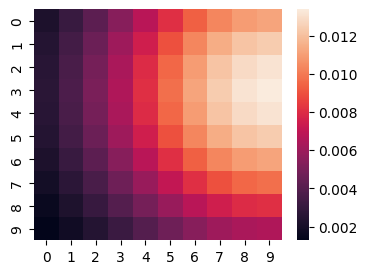

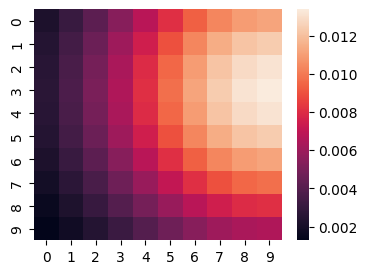

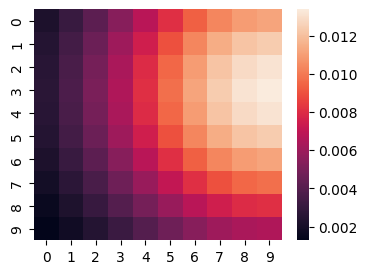

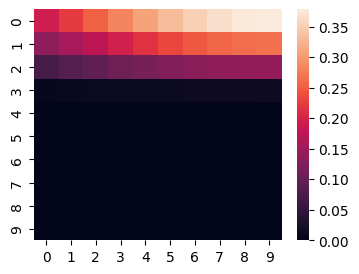

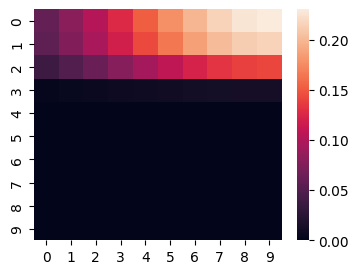

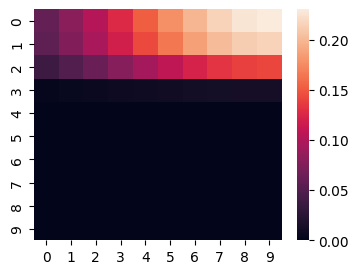

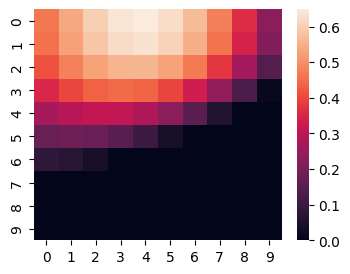

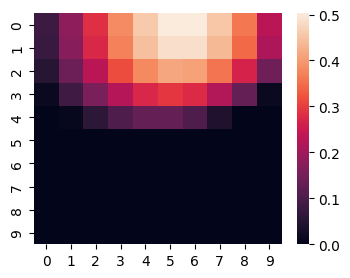

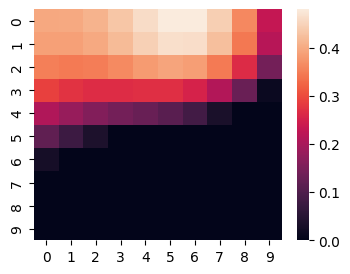

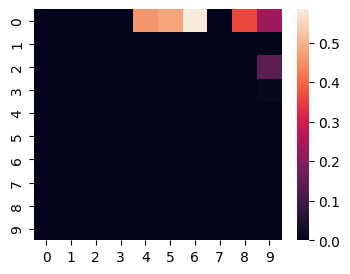

In [77]:
for survey in sim_hist[0].agents[0].surveys:
    fig = plt.figure(figsize=(4,3))
    temp = np.array(survey).reshape(10,10)
    sns.heatmap(temp)
    plt.show()
    
# survey_data = np.array(sim_hist[0].agents[0].surveys[0]).reshape(10,10)
# sns.heatmap(survey_data)

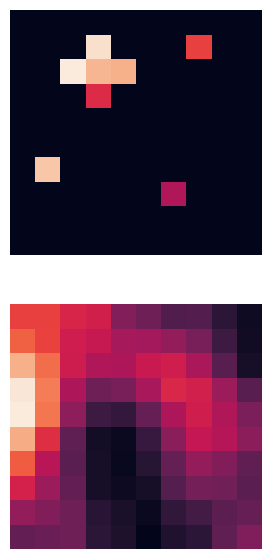

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [31]:
fig, axes = plt.subplots(2,1,figsize=(3.25,7))

ls = sim_hist[0].landscape
for _ in range(2):
    ls = nklsgen.smooth_landscape(ls,stride=1,ratio=0)

locs = [loc for loc,val in np.ndenumerate(ls)]
vals = [val for loc,val in np.ndenumerate(ls)]
x = [a[0] for a in locs]
y = [a[1] for a in locs]
data = {'x':x, 'y':y, 'val':vals}
df_ = pd.DataFrame(data)
df_ = df_.pivot(index='x', columns='y', values='val')
plt.figure(figsize=(4,4))
sns.heatmap(df_, ax=axes.flat[1], cbar=False)

locs = [loc for loc,val in np.ndenumerate(ls)]
keep = [(2,3),(1,3),(2,2),(2,4),(3,3),
       (1,7),(7,6),(6,1)]
vals = [vals[i] if locs[i] in keep else 0 for i,loc in enumerate(locs)]
x = [a[0] for a in locs]
y = [a[1] for a in locs]
data = {'x':x, 'y':y, 'val':vals}
df_ = pd.DataFrame(data)
df_ = df_.pivot(index='x', columns='y', values='val')
plt.figure(figsize=(4,4))
sns.heatmap(df_, ax=axes.flat[0], cbar=False)

for ax in axes.flat:
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
fig.savefig(f'extabs_heu_vs_fl_vis.png')
plt.show()

In [325]:
reds = sns.color_palette('Reds')[0:4]
reds.reverse()
greens = sns.color_palette('Greens')[0:4]
colors = reds + greens

In [305]:
reds = sns.color_palette('Reds')[3]
greens = sns.color_palette('Greens')[3]
colors = [reds]*4 + [greens]*4

In [6]:
cmap = sns.color_palette('rocket_r', as_cmap=True)
colors = cmap(np.linspace(0, 0.75, 8))

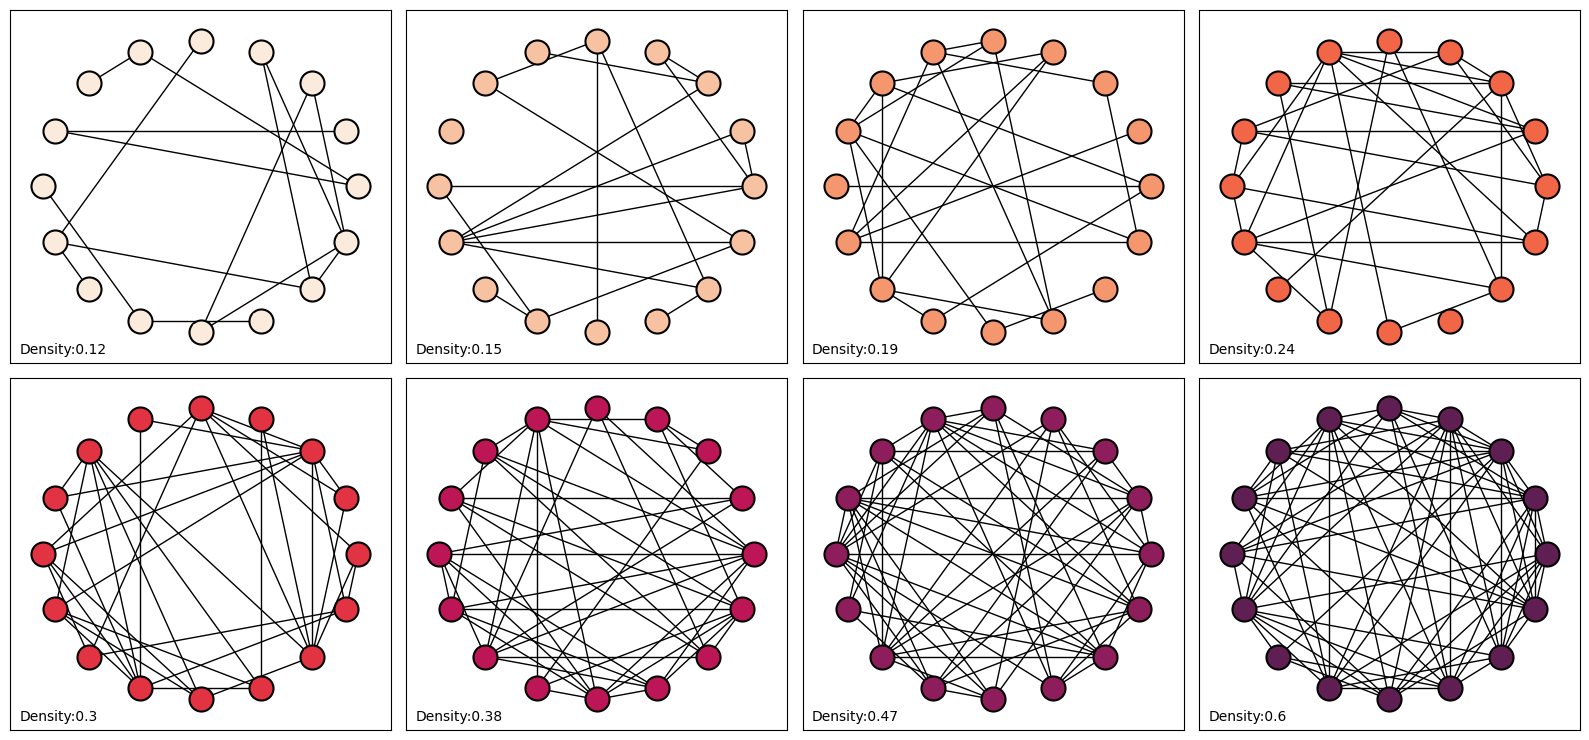

In [12]:
edges = [int(a) for a in np.logspace(np.log10(15),np.log10(72),8)]

fig,axs = plt.subplots(2,4,figsize=(16,7.5))
axes = axs.flatten()
for i,edge in enumerate(edges):
    g = gnm_random_graph(16,edge)
    pos = nx.circular_layout(g)
    if i <= 3:
        nx.draw_networkx(g, pos=pos, ax=axes[i], node_color=colors[i],
                         font_color=colors[i])#"#000000")
    if i > 3:
        nx.draw_networkx(g, pos=pos, ax=axes[i], node_color=colors[i],
                         font_color=colors[i])#"#FFFFFF")
    
    dens = round(edge/120,2)
    axes[i].text(-1.15,-1.15,f'Density:{dens}',fontsize=10)
        
    # Node edge color?
    axes[i].collections[0].set_edgecolor("#000000")   
    axes[i].collections[0].set_linewidth(1.5)

    
plt.tight_layout()
plt.savefig('output/networks_2x4.pdf')
plt.show()

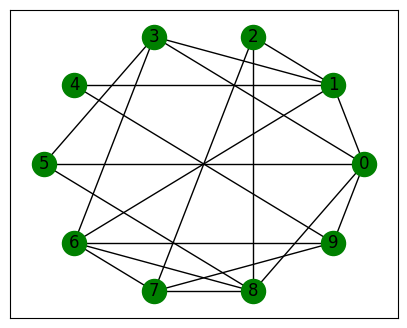

In [127]:
testg = gnm_random_graph(16,20)
pos = nx.circular_layout(testg)
fig = plt.figure(figsize=(5,4))
nx.draw_networkx(testg, pos=pos, node_color='green')
plt.savefig('eff.png', transparent=True)

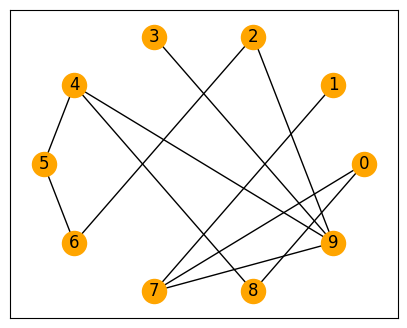

In [122]:
testg = gnm_random_graph(10,11)
pos = nx.circular_layout(testg)
fig = plt.figure(figsize=(5,4))
nx.draw_networkx(testg, pos=pos, node_color='orange')
plt.savefig('ineff.png', transparent=True)

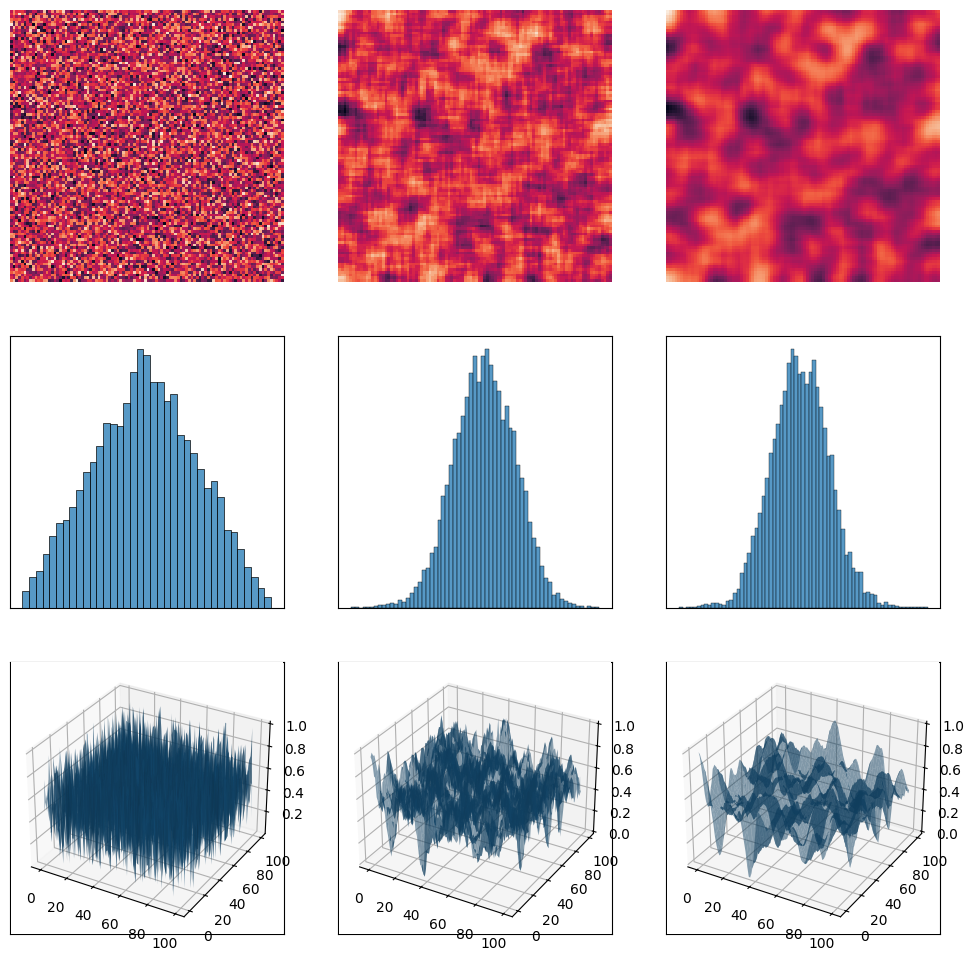

<Figure size 400x400 with 0 Axes>

In [99]:
fig, axes = plt.subplots(3,3,figsize=(12,12))

locs = [loc for loc,val in np.ndenumerate(sim_hist[0].landscape)]
vals = [val for loc,val in np.ndenumerate(sim_hist[0].landscape)]
x = [a[0] for a in locs]
y = [a[1] for a in locs]
data = {'x':x, 'y':y, 'val':vals}
df_ = pd.DataFrame(data)
df_ = df_.pivot(index='x', columns='y', values='val')
plt.figure(figsize=(4,4))
sns.heatmap(df_, ax=axes.flat[0], cbar=False)
sns.histplot(vals, ax=axes.flat[3])
x_ = np.tile(np.array(df_.index), (len(df_.index),1)).T
y_ = np.tile(np.array(df_.columns), (len(df_.columns),1))
ax = fig.add_subplot(337, projection='3d')
ax.plot_surface(x_, y_, df_.values, alpha=0.5)

ls = nklsgen.smooth_landscape(sim_hist[0].landscape, stride=3, ratio=0)
locs = [loc for loc,val in np.ndenumerate(ls)]
vals = [val for loc,val in np.ndenumerate(ls)]
x = [a[0] for a in locs]
y = [a[1] for a in locs]
data = {'x':x, 'y':y, 'val':vals}
df_ = pd.DataFrame(data)
df_ = df_.pivot(index='x', columns='y', values='val')
sns.heatmap(df_, ax=axes.flat[1], cbar=False)
sns.histplot(vals, ax=axes.flat[4])
x_ = np.tile(np.array(df_.index), (len(df_.index),1)).T
y_ = np.tile(np.array(df_.columns), (len(df_.columns),1))
ax = fig.add_subplot(338, projection='3d')
ax.plot_surface(x_, y_, df_.values, alpha=0.5)

ls2 = nklsgen.smooth_landscape(ls, stride=3, ratio=0)
locs = [loc for loc,val in np.ndenumerate(ls2)]
vals = [val for loc,val in np.ndenumerate(ls2)]
x = [a[0] for a in locs]
y = [a[1] for a in locs]
data = {'x':x, 'y':y, 'val':vals}
df_ = pd.DataFrame(data)
df_ = df_.pivot(index='x', columns='y', values='val')
sns.heatmap(df_, ax=axes.flat[2], cbar=False)
sns.histplot(vals, ax=axes.flat[5])
x_ = np.tile(np.array(df_.index), (len(df_.index),1)).T
y_ = np.tile(np.array(df_.columns), (len(df_.columns),1))
ax = fig.add_subplot(339, projection='3d')
ax.plot_surface(x_, y_, df_.values, alpha=0.5)

for ax in axes.flat:
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
fig.savefig(f'extabs_lsvisual.png')
plt.show()

<Axes: ylabel='Count'>

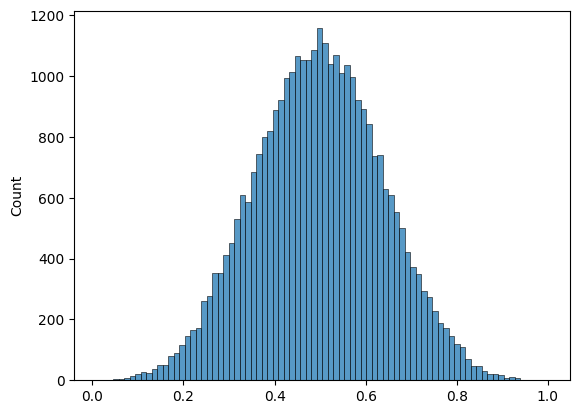

In [8]:
means = [np.mean(sim.landscape) for sim in sim_hist]
sns.histplot(sim_hist[0].landscape.flatten())

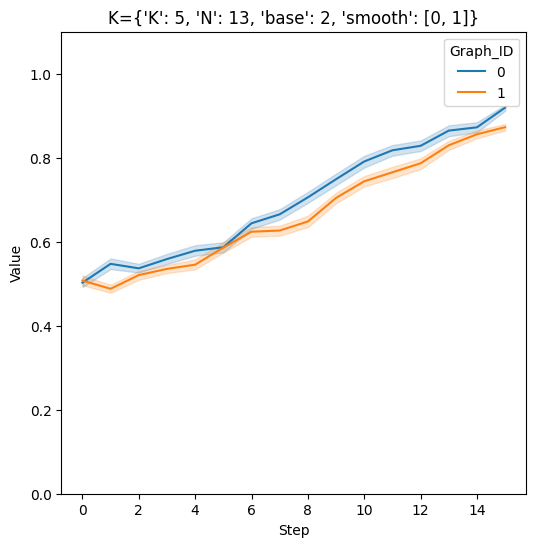

In [44]:
data_ = []
for sim in sim_hist:
    for agent in sim.agents:
        temp = agent.shared_search_hist.copy()
        temp['Memory'] = agent.memory
        temp['Graph_ID'] = sim.graph_id
        temp['LS_params'] = str(sim.ls_params)
        temp['Pop_IDs'] = sim.pop_id
        temp['Search_Cost'] = agent.search_cost
        temp['EIs'] = agent.ei
        data_.append(temp)
    
data = pd.concat(data_)

for ls in sorted(data['LS_params'].unique()):
    temp = data[data['LS_params']==ls].copy()
    plt.figure(figsize=(6,6))
    sns.lineplot(temp, x='Step', y='Value', hue='Graph_ID')
    plt.ylim(0,1.1)
    plt.title(f'K={ls}')
    
    plt.show()

In [ ]:
data_ = []
for sim in sim_hist:
    for agent in sim.agents:
        temp = agent.shared_search_hist.copy()
        temp['Memory'] = agent.memory
        temp['Graph_ID'] = sim.graph_id
        temp['LS_params'] = str(sim.ls_params)
        temp['Pop_IDs'] = sim.pop_id
        temp['Search_Cost'] = agent.search_cost
        temp['EIs'] = agent.ei
        data_.append(temp)
    
data = pd.concat(data_)

for ls in sorted(data['LS_params'].unique()):
    temp = data[data['LS_params']==ls].copy()
    plt.figure(figsize=(6,6))
    sns.lineplot(temp, x='Step', y='Value', hue='Graph_ID')
    plt.ylim(0,1.1)
    plt.title(f'K={ls}')
    
    plt.show()

In [47]:
from scipy.ndimage import convolve

def smooth_landscape(landscape, stride=1, ratio=0.5, norm=True):
    base = len(set([a[0] for a in list(landscape.keys())]))
    dims = len(list(list(landscape.keys())[0]))
    shape = tuple([base for _ in range(dims)])
    data = np.zeros(shape)
    for loc, val in list(np.ndenumerate(data)):
        data[loc] = landscape[loc]

    kernel = np.ones(tuple([1+stride*2 for _ in range(len(data.shape))]))
    if ratio != 0:
        mult = (ratio/(1-ratio))
        elseval = kernel.sum() - 1
        kernel[tuple([1 for _ in range(len(data.shape))])] = elseval*mult
    kernel = kernel/kernel.sum()
    
    smooth_data = convolve(data, kernel)

    if norm: 
        min_, max_ = smooth_data.min(), smooth_data.max()
        diff = max_ - min_
        smooth_data = (smooth_data - min_) / diff
    
    return smooth_data

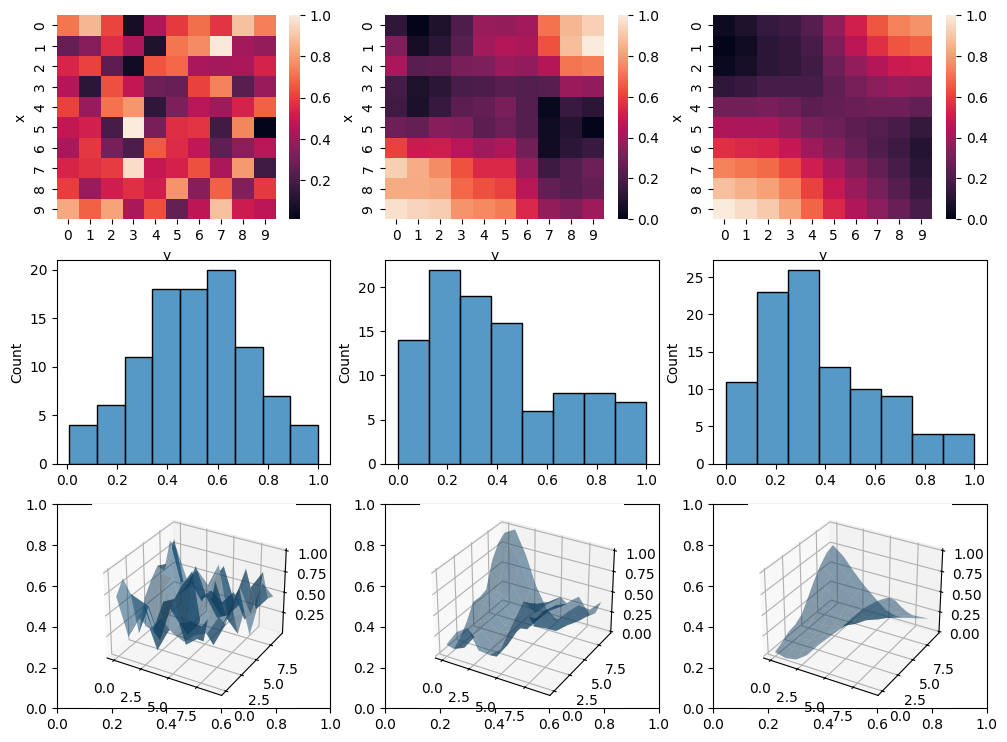

<Figure size 400x400 with 0 Axes>

In [7]:
fig, axes = plt.subplots(3,3,figsize=(12,9))

locs = [loc for loc,val in np.ndenumerate(sim_hist[0].landscape)]
vals = [val for loc,val in np.ndenumerate(sim_hist[0].landscape)]
x = [a[0] for a in locs]
y = [a[1] for a in locs]
data = {'x':x, 'y':y, 'val':vals}
df_ = pd.DataFrame(data)
df_ = df_.pivot(index='x', columns='y', values='val')
plt.figure(figsize=(4,4))
sns.heatmap(df_, ax=axes.flat[0])
sns.histplot(vals, ax=axes.flat[3])
x_ = np.tile(np.array(df_.index), (len(df_.index),1)).T
y_ = np.tile(np.array(df_.columns), (len(df_.columns),1))
ax = fig.add_subplot(337, projection='3d')
ax.plot_surface(x_, y_, df_.values, alpha=0.5)

ls = nklsgen.smooth_landscape(sim_hist[0].landscape, stride=3, ratio=0)
locs = [loc for loc,val in np.ndenumerate(ls)]
vals = [val for loc,val in np.ndenumerate(ls)]
x = [a[0] for a in locs]
y = [a[1] for a in locs]
data = {'x':x, 'y':y, 'val':vals}
df_ = pd.DataFrame(data)
df_ = df_.pivot(index='x', columns='y', values='val')
sns.heatmap(df_, ax=axes.flat[1])
sns.histplot(vals, ax=axes.flat[4])
x_ = np.tile(np.array(df_.index), (len(df_.index),1)).T
y_ = np.tile(np.array(df_.columns), (len(df_.columns),1))
ax = fig.add_subplot(338, projection='3d')
ax.plot_surface(x_, y_, df_.values, alpha=0.5)

ls2 = nklsgen.smooth_landscape(ls, stride=3, ratio=0)
locs = [loc for loc,val in np.ndenumerate(ls2)]
vals = [val for loc,val in np.ndenumerate(ls2)]
x = [a[0] for a in locs]
y = [a[1] for a in locs]
data = {'x':x, 'y':y, 'val':vals}
df_ = pd.DataFrame(data)
df_ = df_.pivot(index='x', columns='y', values='val')
sns.heatmap(df_, ax=axes.flat[2])
sns.histplot(vals, ax=axes.flat[5])
x_ = np.tile(np.array(df_.index), (len(df_.index),1)).T
y_ = np.tile(np.array(df_.columns), (len(df_.columns),1))
ax = fig.add_subplot(339, projection='3d')
ax.plot_surface(x_, y_, df_.values, alpha=0.5)

plt.tight_layout()
plt.show()

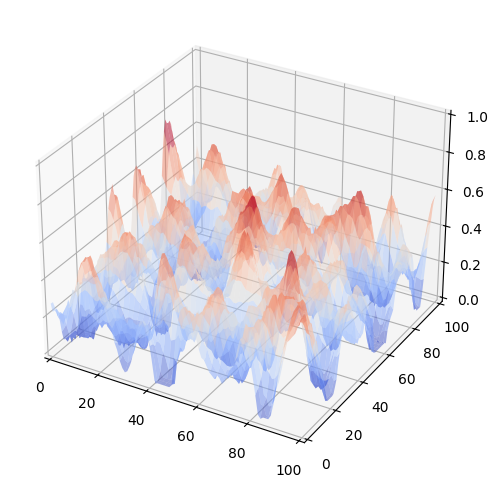

In [79]:
diff = ls2.mean() - 0.3
short = ls2 - diff
short[short<0] = 0.02

locs = [loc for loc,val in np.ndenumerate(short)]
vals = [val for loc,val in np.ndenumerate(short)]
data = {'x':x, 'y':y, 'val':vals}
df_ = pd.DataFrame(data)
df_ = df_.pivot(index='x', columns='y', values='val')

x_ = np.tile(np.array(df_.index), (len(df_.index),1)).T
y_ = np.tile(np.array(df_.columns), (len(df_.columns),1))
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.axes.set_xlim3d(left=0, right=100) 
ax.axes.set_ylim3d(bottom=0, top=100) 
ax.axes.set_zlim3d(bottom=0, top=1) 
ax.plot_surface(x_, y_, df_.values, alpha=0.5, cmap=plt.cm.coolwarm)
plt.savefig('PNAS_LSExample.png')

<Axes: xlabel='y', ylabel='x'>

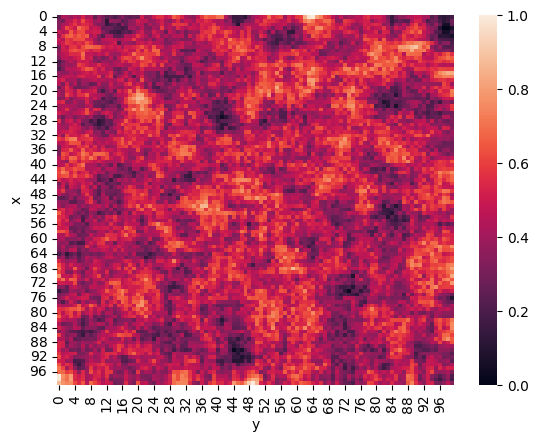

In [92]:
ls = dict(np.ndenumerate(smooth_landscape(sim_hist[0].landscape, stride=3, ratio=0.1)))
locs = [a for a in list(ls.keys())]
vals = list(ls.values())

x = [a[0] for a in locs]
y = [a[1] for a in locs]

data = {'x':x, 'y':y, 'val':vals}
df_ = pd.DataFrame(data)
df_ = df_.pivot(index='x', columns='y', values='val')
sns.heatmap(df_)

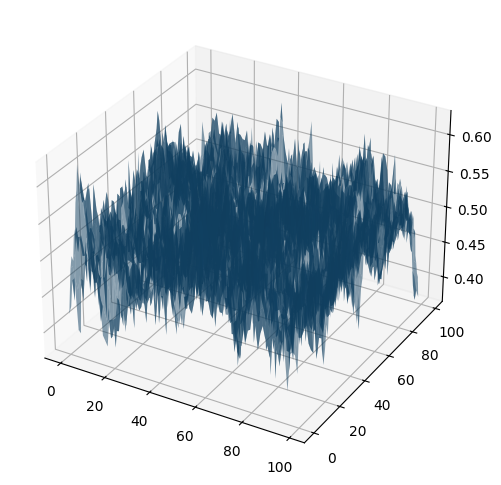

In [333]:
x_ = np.tile(np.array(df_.index), (len(df_.index),1)).T
y_ = np.tile(np.array(df_.columns), (len(df_.columns),1))
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_, y_, df_.values, alpha=0.5)

In [271]:
from scipy.ndimage import convolve
ratio = 0.10
data = np.random.rand(5,5)
kernel = np.ones(tuple([3 for _ in range(len(data.shape))]))
mult = (ratio/(1-ratio))
elseval = kernel.sum() - 1
# kernel[tuple([1 for _ in range(len(data.shape))])] = elseval*mult
kernel = kernel/kernel.sum()

smooth_data = convolve(data, kernel)

In [ ]:
# x = list(range(num_searches[0]))
# y = sim_hist[0].agents[0].timeperround

# plt.plot(x,y)
# plt.xlabel(f'Input Count')
# plt.ylabel(f'Time (sec)')

# plt.title(f'Survey Time Scaling (18,5)')

# plt.savefig(f'output/SurveyTimeScaling(18,5).png')
# plt.show()

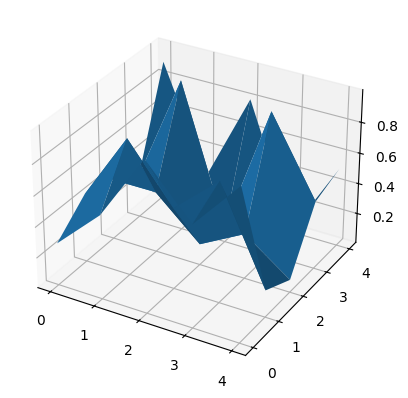

In [272]:
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(data.shape[0]), range(data.shape[1]))  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, data)
plt.show()

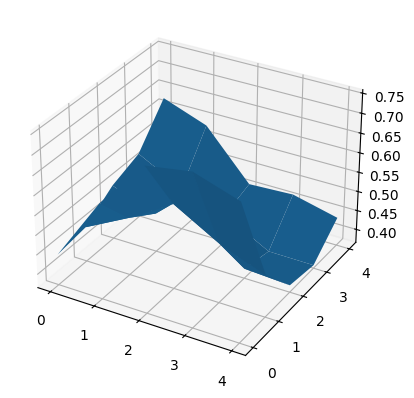

In [273]:
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(data.shape[0]), range(data.shape[1]))  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, smooth_data)
plt.show()

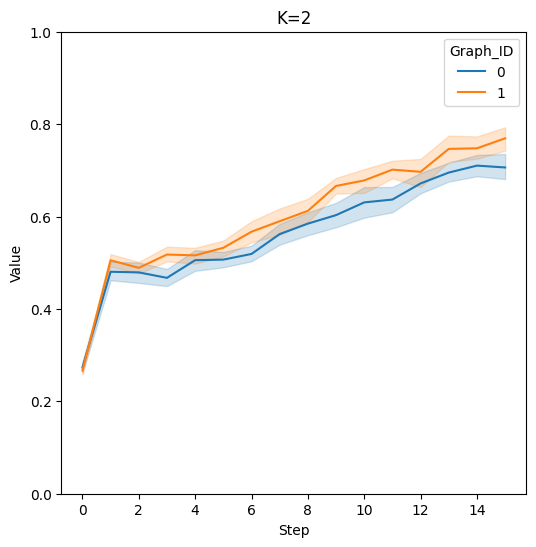

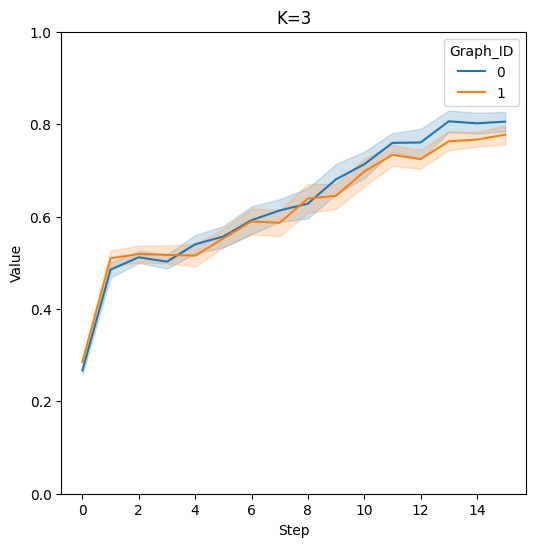

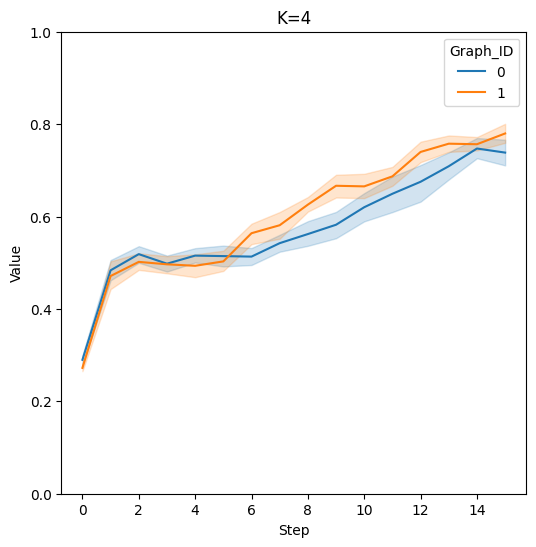

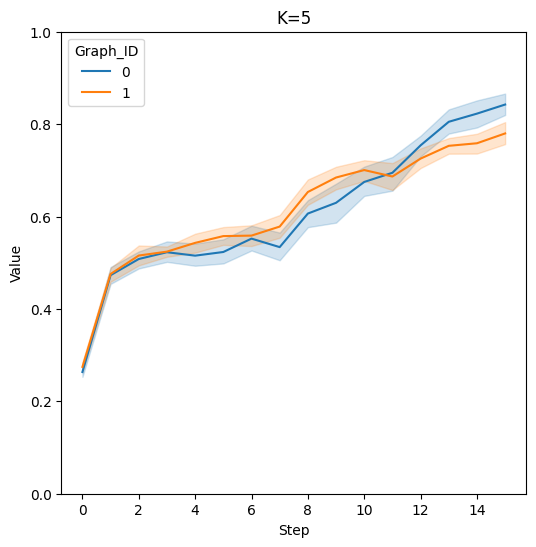

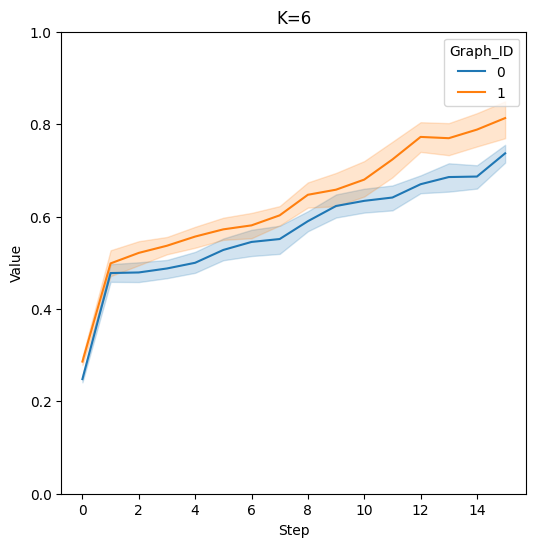

In [157]:
data_ = []
for sim in sim_hist:
    for agent in sim.agents:
        temp = agent.shared_search_hist.copy()
        temp['Memory'] = agent.memory
        temp['Graph_ID'] = sim.graph_id
        temp['LS_params'] = sim.ls_params['scale']
        data_.append(temp)
    
data = pd.concat(data_)
data = data.groupby(['Graph_ID','Step','AgentID', 'Memory', 'LS_params'])['Value'].mean().copy()
data = data.reset_index()

for graph_id in sorted(data['LS_params'].unique()):
    temp = data[data['LS_params']==graph_id].copy()
    plt.figure(figsize=(6,6))
    sns.lineplot(temp, x='Step', y='Value', hue='Graph_ID')
    plt.ylim(0,1)
    plt.title(f'K={graph_id}')
    
    plt.show()

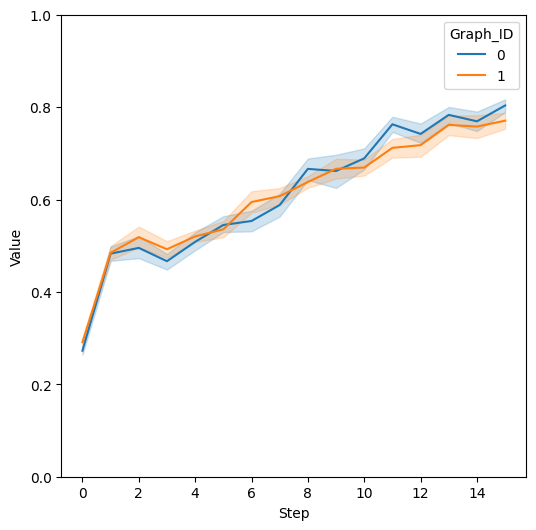

In [104]:
# LS_100x100x2 & 10 sims (graphs 0,1) & capped 10 (OOF)
data_ = []
for sim in sim_hist:
    for agent in sim.agents:
        temp = agent.shared_search_hist.copy()
        temp['Memory'] = agent.memory
        temp['Graph_ID'] = sim.graph_id
        data_.append(temp)
    
data = pd.concat(data_)
data = data.groupby(['Graph_ID','Step','AgentID', 'Memory'])['Value'].mean().copy()
data = data.reset_index()

plt.figure(figsize=(6,6))
sns.lineplot(data, x='Step', y='Value', hue='Graph_ID')
plt.ylim(0,1)

plt.show()

In [47]:
simid = []
perf = []
for i, sim in enumerate(sim_hist):
    simid.append(i)
    perf.append(sim.agents[0].search_hist['Value'][-1:].tolist()[0])

In [51]:
perf.index(max(perf))

51

In [67]:
plt.figure(figsize=(6,5))

sns.heatmap(landscape, cmap='Blues', vmin=0, vmax=1)

plt.gca().invert_yaxis()
plt.title(f'True Landscape', fontsize=15)

plt.gca().set_xticks([])
plt.gca().set_yticks([])

# plt.savefig(f'ani_true_ls.png')
plt.clf()

<Figure size 600x500 with 0 Axes>

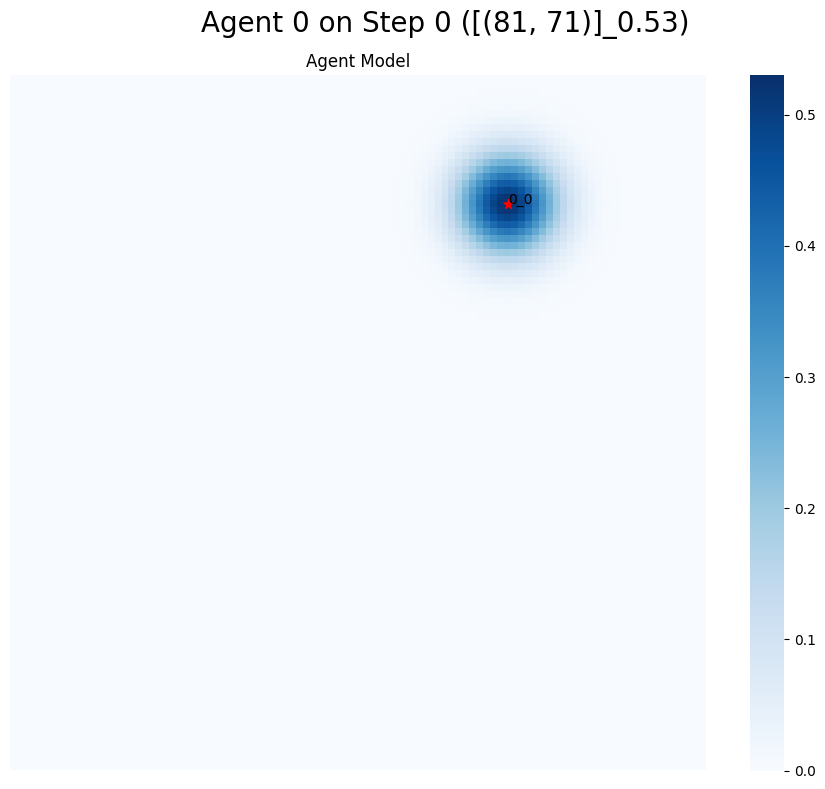

<Figure size 640x480 with 0 Axes>

In [63]:
sim = sim_hist[0]
landscape = sim.landscape

for i, agent in enumerate(sim.agents):
    
    for step in range(num_searches[0]):
        
        data = gather_data(agent, step)

        fig, axes = plt.subplots(1,1, figsize=(9,8))
        
        max_dist = 100+100-2
        
        neighbors = len(agent.neighbors)
        amount = (neighbors + 1)*agent.memory
        relevant_hist = agent.shared_search_hist[agent.shared_search_hist['Step']<=step].copy()
        locs = relevant_hist[-amount:]['Location'].tolist()
        nums = relevant_hist[-amount:]['AgentID'].tolist()
        steps = relevant_hist[-amount:]['Step'].tolist()
        labels = [f'{nums[a]}_{steps[a]}' for a in range(len(nums))]
        x = [a[0]+0.5 for a in locs]
        y = [a[1]+0.5 for a in locs]

        sns.heatmap(data['Survey'], cmap='Blues', ax=axes)
        axes.set_title(f'Agent Model')
        
        axes.scatter(y, x, color='red', s=50, marker='*')
        axes.invert_yaxis()
            
        for i, txt in enumerate(labels):
            axes.annotate(txt, (y[i], x[i]))
        
        axes.set_xticks([])
        axes.set_yticks([])

        fig.gca().set_xticks([])
        fig.gca().set_yticks([])

        position = agent.search_hist.loc[step]['Location']
        perf = round(agent.search_hist.loc[step]['Value'], 2)
        fig.suptitle(f'Agent {agent.id} on Step {step} ([{position}]_{perf})', fontsize=20)
        plt.tight_layout()

        # plt.savefig(f'PerlinLS_Vis/image{agent.id}_{step}.png')
        plt.show()
        plt.clf()

In [71]:
sim = sim_hist[51]
landscape = np.array(list(sim.landscape.values())).reshape(75,75)

for i, agent in enumerate(sim.agents):
    
    for step in range(num_searches[0]):
        
        data = gather_data(agent, step)

        fig, axes = plt.subplots(1,1, figsize=(9,8))
        
        max_dist = 75+75-2
        
        neighbors = len(agent.neighbors)
        amount = (neighbors + 1)*agent.memory
        relevant_hist = agent.shared_search_hist[agent.shared_search_hist['Step']<=step].copy()
        locs = relevant_hist[-amount:]['Location'].tolist()
        nums = relevant_hist[-amount:]['AgentID'].tolist()
        steps = relevant_hist[-amount:]['Step'].tolist()
        labels = [f'{nums[a]}_{steps[a]}' for a in range(len(nums))]
        x = [float(a.split(',')[0])+0.5 for a in locs]
        y = [float(a.split(',')[1])+0.5 for a in locs]

        sns.heatmap(landscape, cmap='Blues', vmin=0, vmax=1, ax=axes)
        axes.set_title(f'Agent Model')
        
        axes.scatter(y, x, color='red', s=50, marker='*')
        axes.invert_yaxis()
            
        for i, txt in enumerate(labels):
            axes.annotate(txt, (y[i], x[i]))
        
        axes.set_xticks([])
        axes.set_yticks([])

        fig.gca().set_xticks([])
        fig.gca().set_yticks([])

        position = agent.search_hist.loc[step]['Location']
        perf = round(agent.search_hist.loc[step]['Value'], 2)
        fig.suptitle(f'Agent {agent.id} on Step {step} ([{position}]_{perf})', fontsize=20)
        plt.tight_layout()

        plt.savefig(f'PerlinLS_Vis/ls{agent.id}_{step}.png')
#         plt.show()
        plt.clf()

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

MovieWriter Pillow unavailable; using Pillow instead.


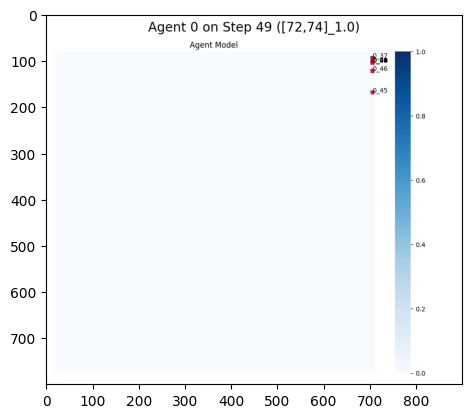

In [70]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import os

files = ['PerlinLS_Vis/'+file for file in sorted(os.listdir(f'PerlinLS_Vis')) if 'image' in file]
files = sorted(files, key=lambda x: int(x.split('_')[2].split('.')[0]))
images = [plt.imread(file) for file in files] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for image in images:
    frames.append([plt.imshow(image, animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('animation.gif', writer='Pillow', fps=2)
# plt.show()

MovieWriter Pillow unavailable; using Pillow instead.


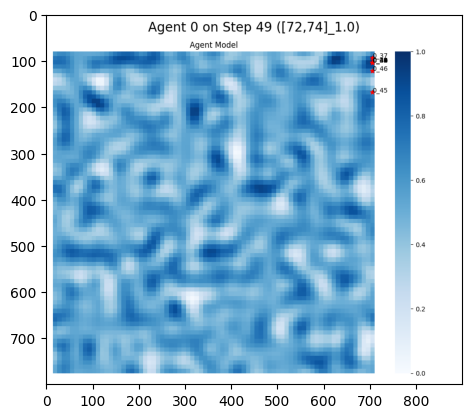

In [72]:
files = ['PerlinLS_Vis/'+file for file in sorted(os.listdir(f'PerlinLS_Vis')) if 'ls' in file]
files = sorted(files, key=lambda x: int(x.split('_')[2].split('.')[0]))
images = [plt.imread(file) for file in files] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for image in images:
    frames.append([plt.imshow(image, animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('ls.gif', writer='Pillow', fps=2)
# plt.show()

In [77]:
sim = sim_hist[51]
landscape = np.array(list(sim.landscape.values())).reshape(75,75)

for i, agent in enumerate(sim.agents):
    
    for step in range(num_searches[0])[0:10]:
        
        data = gather_data(agent, step)

        fig, axes = plt.subplots(2,2, figsize=(9,8))
        
        max_dist = 75+75-2
        
        neighbors = len(agent.neighbors)
        amount = (neighbors + 1)*agent.memory
        relevant_hist = agent.shared_search_hist[agent.shared_search_hist['Step']<=step].copy()
        locs = relevant_hist[-amount:]['Location'].tolist()
        nums = relevant_hist[-amount:]['AgentID'].tolist()
        steps = relevant_hist[-amount:]['Step'].tolist()
        labels = [f'{steps[a]}_{nums[a]}' for a in range(len(nums))]
        x = [float(a.split(',')[0])+0.5 for a in locs]
        y = [float(a.split(',')[1])+0.5 for a in locs]

        sns.heatmap(data['Survey'], cmap='Greens', ax=axes.flat[0])
        sns.heatmap(data['Softmax'], cmap='Greens', ax=axes.flat[1])
        sns.heatmap(data['Survey'], cmap='Blues', vmin=0, vmax=1, ax=axes.flat[2])
        sns.heatmap(landscape, cmap='Blues', vmin=0, vmax=1, ax=axes.flat[3])
        
        axes.flat[0].set_title(f'Survey')
        axes.flat[1].set_title(f'Softmax')
        axes.flat[2].set_title(f'Agent Model')
        axes.flat[3].set_title(f'True Landscape')
        
        for ax in axes.flat:
            ax.scatter(y, x, color='red', s=15, marker='*')
            ax.invert_yaxis()
            
            for i, txt in enumerate(labels):
                ax.annotate(txt, (y[i], x[i]))            

            ax.set_xticks([])
            ax.set_yticks([])
#         axes.flat[-1].set_visible(False) # to remove last plot

        position = agent.search_hist.loc[step]['Location']
        perf = round(agent.search_hist.loc[step]['Value'], 2)
        fig.suptitle(f'Agent {i} on Step {step} ([{position}]_{perf})', fontsize=20)
        plt.tight_layout()

        plt.savefig(f'QuadVis/image{agent.id}_{step}.png')
        # plt.show()
        plt.clf()

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

<Figure size 900x800 with 0 Axes>

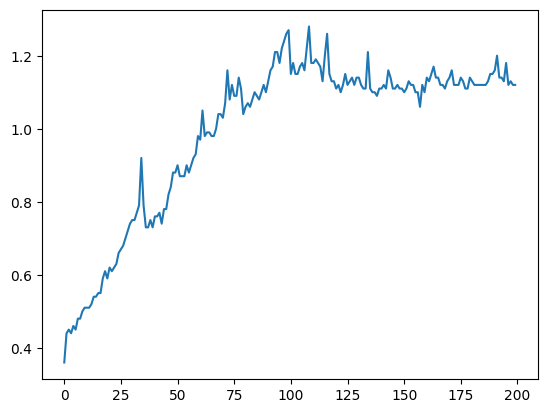

In [12]:
y = sim_hist[0].time_per_step
x = range(len(y))

plt.plot(x,y)

In [13]:
sim_index = []
step_index = []
avg_value = []
search_costs_= []
memories = []
densities_ = []
ls_params_ = []
pop_ids_ = []
graph_ids_ = []

for i, pop in enumerate(sim_hist):

    # filename_ = f'./{folder_}/landscapes/'
    # pop.landscape.tofile(f'{filename_}{pop.id_}_landscape.csv', sep=',')

    for j in range(pop.num_searches+1):

        # Sim + Step Indices
        #sim_index.append(f'{rank}_{i+1}')
        step_index.append(j)

        # Average Agent Value at each Step
#         agent_vals = []
#         for agent in pop.agents:
#             agent_vals.append(agent.search_hist['Value'][j])
#         avg_value.append((sum(agent_vals) / len(agent_vals)))
        avg_value.append(np.mean(pop.report_step_averages(j)))

        # Agent Properties
        search_costs_.append(pop.search_costs[0])
        memories.append(pop.memorys[0])

        # Graph Properties
        densities_.append(pop.graphdensity)

        # IDs
        ls_params_.append(pop.ls_params)
#         pop_ids_.append(pop.pop_id)
#         graph_ids_.append(pop.graph_id)

data = {#'Sim_ID': sim_index, 
        'Step': step_index, 
        'AVG_Value': avg_value, 
        'Search_Cost': search_costs_,
        'Memory': memories,
        'Densities': densities_,
        'LS_Params': ls_params_
        #'Pop_IDs': pop_ids_,
        #'Graph_IDs': graph_ids_
        }


df = pd.DataFrame(data)

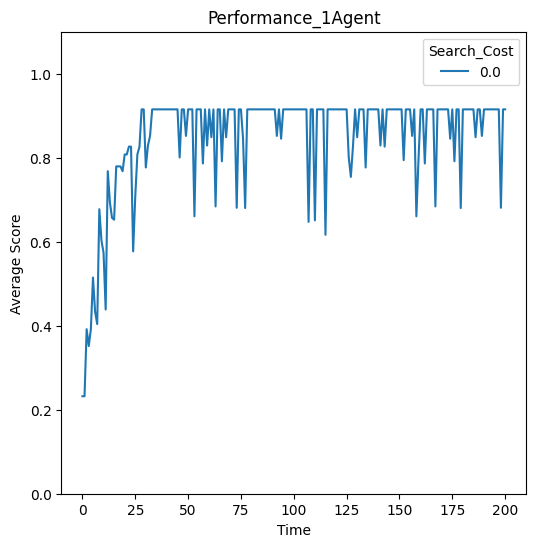

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(figsize=(6,6))

sns.lineplot(data=df, x='Step', y='AVG_Value', hue='Search_Cost')

plt.ylim(0,1.1)

plt.xlabel('Time')
plt.ylabel('Average Score')

plt.title(f'Performance_1Agent')
# plt.savefig(f'16AgentPerf_SearchCost.jpg')

plt.show()
plt.clf()

In [293]:
steps = []
step_size = []
sc = []
agentid = []


for pop in sim_hist:
    for agent in pop.agents:
        agent_hist = agent.shared_search_hist.copy()
        amem = agent.memory

        for step in range(1, pop.num_searches+1):
            steps.append(step)

            temp = agent_hist[agent_hist['Step'].isin(list(range(step-amem,step)))]
            self = temp[(temp['AgentID']==agent.id) & (temp['Step']==step-1)]['Location'].apply(str_to_bin).tolist()
    #         print(self)
            neigh = temp[temp['AgentID']!=agent.id]['Location'].apply(str_to_bin).tolist()
    #         print(neigh)
            ls_idx = agent_hist[(agent_hist['Step']==step) & (agent_hist['AgentID']==agent.id)]['Location'].apply(str_to_bin).tolist()
    #         print(ls_idx)
            step_size.append(vectorized_dist(self, neigh, ls_idx)[0])

            sc.append(agent.search_cost)
            agentid.append(agent.id)

data = {'Step': steps,
       'StepSize': step_size,
       'SearchCost': sc,
       'AgentID': agentid}
ss_df = pd.DataFrame(data)

In [303]:
ss_df

Step  StepSize  SearchCost  AgentID
0         1       1.0         0.0        0
1         2       0.0         0.0        0
2         3       0.0         0.0        0
3         4       0.0         0.0        0
4         5       0.0         0.0        0
...     ...       ...         ...      ...
10995    96       0.0         0.2        0
10996    97       0.0         0.2        0
10997    98       0.0         0.2        0
10998    99       0.0         0.2        0
10999   100       0.0         0.2        0

[11000 rows x 4 columns]

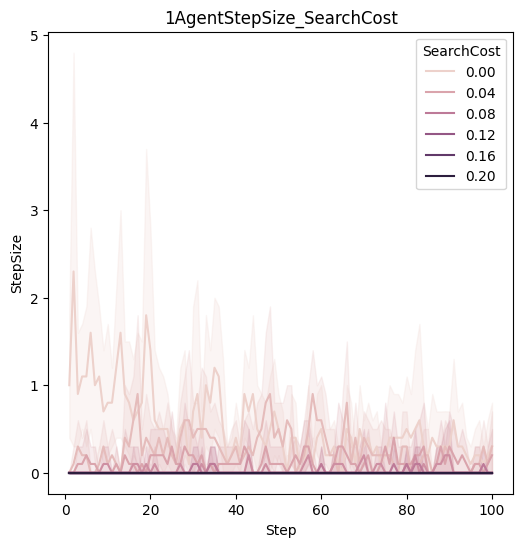

In [294]:
plt.figure(figsize=(6,6))
sns.lineplot(data=ss_df, x='Step', y='StepSize', hue='SearchCost')

plt.title('1AgentStepSize_SearchCost')
# plt.savefig('1AgentStepSize_SearchCost.jpg')

plt.show()

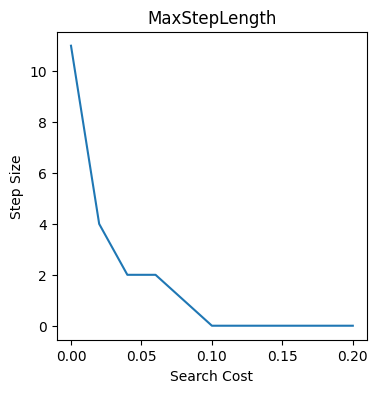

In [296]:
x = []
y = []

for sc_ in sorted(ss_df['SearchCost'].unique()):
    temp = ss_df[ss_df['SearchCost']==sc_].copy()
    x.append(sc_)
    y.append(temp['StepSize'].max())
    
plt.figure(figsize=(4,4))

sns.lineplot(x=x, y=y)

plt.xlabel('Search Cost')
plt.ylabel('Step Size')

plt.title('MaxStepLength')
# plt.savefig('1AgentMaxStepSize_SearchCost.jpg')

plt.show()


In [300]:
x = []
y = []
mem = []
for pop in sim_hist:
    hist_df = hist_df_maker(pop)
    for step in sorted(hist_df['Step'].unique()):
        x.append(step)
        y.append(len(hist_df[hist_df['Step']==step]['Location'].unique()))
        mem.append(pop.agents[0].memory)


<Axes: >

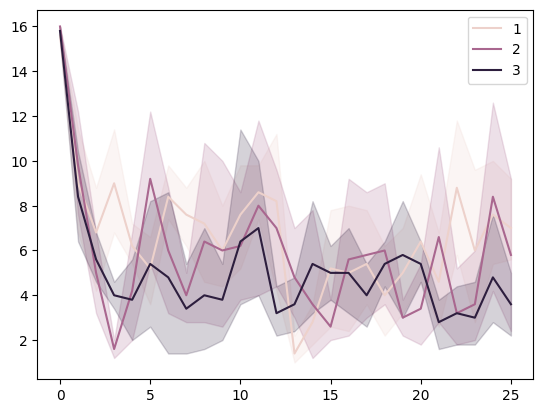

In [301]:
sns.lineplot(x=x, y=y, hue=mem)

In [279]:
hist = sim_hist[0].agents[0].shared_search_hist

step_ = []
avg_locs = []
for pop in sim_hist:
    hist = pop.agents[0].shared_search_hist.copy()
    avg_locs_ = []
    for step in hist['Step'].unique():
        temp = hist[hist['Step']==step].copy()
#         avg_locs_.append(len(temp['Location'].unique()))
        step_.append(step)
        avg_locs.append(len(temp['Location'].unique()))
    
#     avg_locs += avg_locs_

<Axes: >

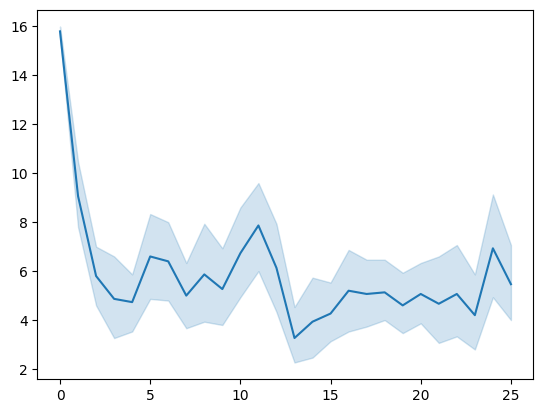

In [284]:
sns.lineplot(x=step_, y=avg_locs)

In [261]:
for each in avg_locs:
    print(np.mean(each))

6.538461538461538
6.346153846153846
6.846153846153846
6.653846153846154
7.1923076923076925
5.384615384615385
6.423076923076923
4.923076923076923
5.461538461538462
7.0
4.846153846153846
4.846153846153846
4.653846153846154
6.153846153846154
5.0
